In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split


# Ścieżki do katalogów z danymi
paths = [
    "chest_xray/train/NORMAL", "chest_xray/train/PNEUMONIA",
    "chest_xray/test/NORMAL", "chest_xray/test/PNEUMONIA",
    "chest_xray/val/NORMAL", "chest_xray/val/PNEUMONIA"
]

list_total = []

for path in paths:
    # Ustalenie etykiety na podstawie nazwy katalogu
    label = 0 if "NORMAL" in path else 1
    # Przejście przez wszystkie pliki w danym katalogu
    for img in os.listdir(path):
        # Pełna ścieżka do pliku
        full_path = os.path.join(path, img)
        # Dodanie ścieżki i etykiety do listy
        list_total.append([full_path, label])

# Przykładowe wyświetlenie pierwszych 5 elementów listy
print(list_total[:5])

[['chest_xray/train/NORMAL\\IM-0115-0001.jpeg', 0], ['chest_xray/train/NORMAL\\IM-0117-0001.jpeg', 0], ['chest_xray/train/NORMAL\\IM-0119-0001.jpeg', 0], ['chest_xray/train/NORMAL\\IM-0122-0001.jpeg', 0], ['chest_xray/train/NORMAL\\IM-0125-0001.jpeg', 0]]


In [26]:
# Tworzymy DataFrame
df_total = pd.DataFrame(list_total, columns=['image', 'label'])

# Mieszamy dane
df_total = df_total.sample(frac=1)

# Dzielimy na podzbiory
X_total = df_total['image']
y_total = df_total['label']

X_train, X_temp, y_train, y_temp = train_test_split(X_total, y_total, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print(f'Liczebność zbioru treningowego: {len(X_train)}')
print(f'Liczebność zbioru testowego: {len(X_test)}')
print(f'Liczebność zbioru walidacyjnego: {len(X_val)}')

Liczebność zbioru treningowego: 4099
Liczebność zbioru testowego: 879
Liczebność zbioru walidacyjnego: 878


In [27]:
import cv2
import numpy as np

def process_data(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (256, 256))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img / 255.0
    img = np.reshape(img, (256, 256, 1))
    
    return img

def compose_dataset(X, y):
    data = []
    labels = []
    
    for img_path, label in zip(X, y):
        data.append(process_data(img_path))
        labels.append(label)
        
    return np.array(data), np.array(labels).reshape(-1, 1)

# Przygotowanie danych
X_train, y_train = compose_dataset(X_train, y_train)
X_test, y_test = compose_dataset(X_test, y_test)
X_val, y_val = compose_dataset(X_val, y_val)

Typ X_val: <class 'numpy.ndarray'>
Typ y_val: <class 'numpy.ndarray'>
Kształt X_val: (878, 256, 256, 1)
Kształt y_val: (878, 1)
Maksymalny indeks w y_val: 1
Rozmiar X_val: 878
Pierwsze 5 etykiet w y_val: [[1]
 [0]
 [0]
 [0]
 [1]]
Pierwszy obraz w X_val: [[[0.29803922]
  [0.28627451]
  [0.2627451 ]
  ...
  [0.79215686]
  [0.78823529]
  [0.79215686]]

 [[0.30588235]
  [0.25882353]
  [0.24705882]
  ...
  [0.78823529]
  [0.81176471]
  [0.81176471]]

 [[0.29803922]
  [0.27058824]
  [0.25490196]
  ...
  [0.79607843]
  [0.80392157]
  [0.79215686]]

 ...

 [[0.07058824]
  [0.05098039]
  [0.04705882]
  ...
  [0.04705882]
  [0.05098039]
  [0.05098039]]

 [[0.06666667]
  [0.05098039]
  [0.04705882]
  ...
  [0.04705882]
  [0.05098039]
  [0.05098039]]

 [[0.0627451 ]
  [0.04705882]
  [0.04705882]
  ...
  [0.04705882]
  [0.05098039]
  [0.05098039]]]
Zbalansowanie klas w y_val: {0: 252, 1: 626}


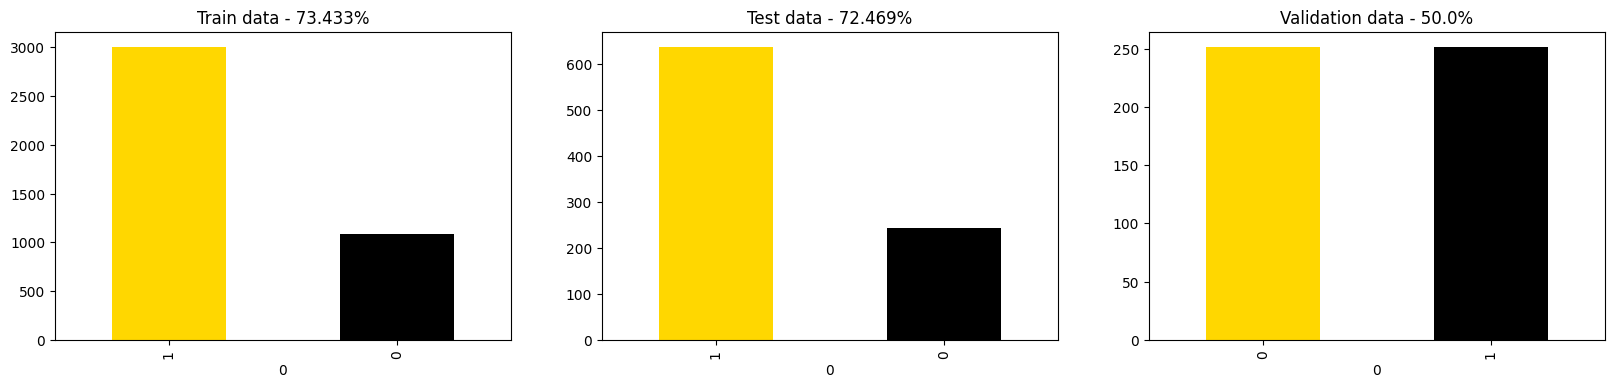

In [28]:
from tensorflow.keras.utils import to_categorical

#Balansowanie zbioru walidacyjnego
import numpy as np
from sklearn.utils import shuffle


# Sprawdź typy danych
print(f"Typ X_val: {type(X_val)}")
print(f"Typ y_val: {type(y_val)}")

# Sprawdź kształt tablic
print(f"Kształt X_val: {X_val.shape}")
print(f"Kształt y_val: {y_val.shape}")

# Zakładając, że y_val zawiera etykiety jako pojedynczą kolumnę
# Sprawdź zakres indeksów
print(f"Maksymalny indeks w y_val: {y_val.max()}")
print(f"Rozmiar X_val: {X_val.shape[0]}")

# Upewnij się, że zakres indeksów jest poprawny
assert y_val.max() < X_val.shape[0], "Indeks jest poza zakresem!"

# Sprawdź zawartość tablic
print("Pierwsze 5 etykiet w y_val:", y_val[:5])
print("Pierwszy obraz w X_val:", X_val[0])

# Sprawdź zbalansowanie klas
unique, counts = np.unique(y_val, return_counts=True)
print("Zbalansowanie klas w y_val:", dict(zip(unique, counts)))


def balance_validation_set(X, y):
    # Znajdź indeksy dla każdej klasy
    class_0_indices = np.where(y == 0)[0]
    class_1_indices = np.where(y == 1)[0]
    
    # Upewnij się, że nie próbujesz wybrać więcej przykładów niż istnieje
    n_samples = min(len(class_0_indices), len(class_1_indices))
    
    # Zbalansuj klasy
    np.random.seed(0) # Ustaw seed dla powtarzalności
    class_0_indices_balanced = np.random.choice(class_0_indices, size=n_samples, replace=False)
    class_1_indices_balanced = np.random.choice(class_1_indices, size=n_samples, replace=False)
    
    # Połącz indeksy i przetasuj
    balanced_indices = np.concatenate((class_0_indices_balanced, class_1_indices_balanced))
    balanced_indices = shuffle(balanced_indices, random_state=0)
    
    # Zastosuj indeksy do X i y
    X_balanced = X[balanced_indices]
    y_balanced = y[balanced_indices]
    
    return X_balanced, y_balanced

# Użyj funkcji do zbalansowania zbioru walidacyjnego
X_val_balanced, y_val_balanced = balance_validation_set(X_val, y_val)

#Konwersja etykiet na format kategoryczny
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val_balanced = to_categorical(y_val_balanced)

import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(20,4))

# Wykres dla zbioru treningowego
# Wykres dla zbioru treningowego
plt.subplot(1,3,1)
pd.DataFrame(y_train.argmax(axis=1))[0].value_counts().plot(kind='bar', color=['gold','black'])
percentage_of_class_1 = 100 * np.sum(y_train[:, 1]) / len(y_train)
plt.title(f'Train data - {round(percentage_of_class_1, 3)}%')

# Wykres dla zbioru testowego
plt.subplot(1,3,2)
pd.DataFrame(y_test.argmax(axis=1))[0].value_counts().plot(kind='bar', color=['gold','black'])
percentage_of_class_1_test = 100 * np.sum(y_test[:, 1]) / len(y_test)
plt.title(f'Test data - {round(percentage_of_class_1_test, 3)}%')

# Wykres dla zbioru walidacyjnego
plt.subplot(1,3,3)
pd.DataFrame(y_val_balanced.argmax(axis=1))[0].value_counts().plot(kind='bar', color=['gold','black'])
percentage_of_class_1_val = 100 * np.sum(y_val_balanced[:, 1]) / len(y_val_balanced)
plt.title(f'Validation data - {round(percentage_of_class_1_val, 3)}%')
plt.show()